In [7]:
#|default_exp challange/lion

# Laion

## Init

In [1]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm
from miniai.challange.base import *

In [ ]:
tds = setup_fasion_mnist()

Reseed: 1


In [ ]:
# leaky=0.0, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, loss_func=F.cross_entropy, bs=256, sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW,
# adding values to partial duplicates 
run = partial(run, tds=tds.cached)

In [ ]:
upscale32 = Upscale(28, align=True, const=-0.800000011920929)

In [5]:
run, model_base_resnet, timm_model, model9_ct

(functools.partial(<function run at 0x7f6d2722e3b0>, tds={ train: (#60000), test: (#10000) }),
 <function miniai.challange.base.model_base_resnet()>,
 <function miniai.challange.base.timm_model(name, resize=Identity(), leaky=0.0, **kw)>,
 <function miniai.challange.base.model9_ct(**kw)>)

In [6]:
RNG.new_seed

1

In [7]:
# Impl: dadapt, lion, adamw, mixup

In [8]:
#| export
import dadaptation
def dadapt_adam():return dict(opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,)

In [9]:
#| export
def adamw(lr=1e-2, wd=0.01, **kw): return dict(opt_func=partial(optim.AdamW, weight_decay=wd), base_lr=1e-2, **kw)

In [10]:
#| export
def mixup(alpha=0.4,lbl_smooth=0.1, **kw): return dict(train_cb=MixUpFP16CB(alpha=alpha,use_prev=True,label_smoothing=lbl_smooth), **kw)

## lion

In [11]:
# copy from google repo
from torch.optim.optimizer import Optimizer


class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.
    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.
    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.
    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)
        p.add_(torch.sign(update), alpha=-group['lr'])
        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

def lion(lr=2e-3,**kw): return dict(opt_func=Lion, base_lr=lr, **kw) 

In [12]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            lion(2e-3),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, tta=True, fit=False)

Reseed: 1
Batch size 2048
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
TTA: 0.1


In [13]:
del learn.cbs[3]

In [14]:
learn.cbs+=[ProgressCB()]

Reseed: 1


accuracy,loss,epoch,train
0.320,1.973,0,train


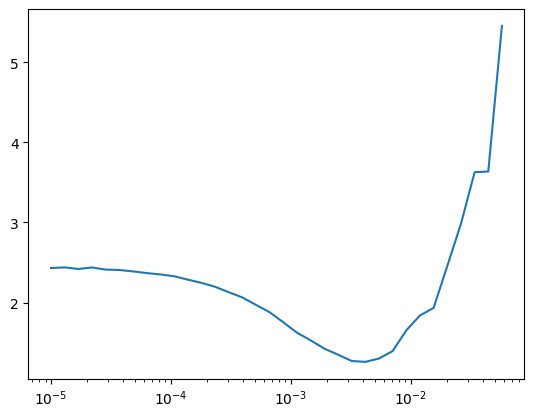

In [15]:
learn.lr_find()

In [16]:
#|export
def save_model(learn, name):
    from accelerate import Accelerator
    mdl_path = Path.home()/"models"/"fmnist"
    mdl_path.mkdir(parents=True,exist_ok=True)
    model=learn.cbs[-1].acc.unwrap_model(learn.model)
    state_dict = model.state_dict()
    learn.cbs[-1].acc.save(state_dict,  mdl_path/name)

In [7]:
AccelerateCB??

Init signature: AccelerateCB(n_inp=1, mixed_precision='fp16')
Docstring:      <no docstring>
Source:        
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)
File:           ~/workspace/part2/course22p2/miniai/accel.py
Type:           type
Subclasses:     MixUpFP16CB

# Experiments

## 95.16% lion(2e-3, bs=2048) (227.53s)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.252,2.157,0,train
0.456,1.844,0,eval
0.475,1.685,1,train
0.638,1.206,1,eval
0.610,1.292,2,train
0.721,0.843,2,eval
0.701,0.998,3,train
0.737,0.731,3,eval
0.764,0.794,4,train
0.803,0.585,4,eval


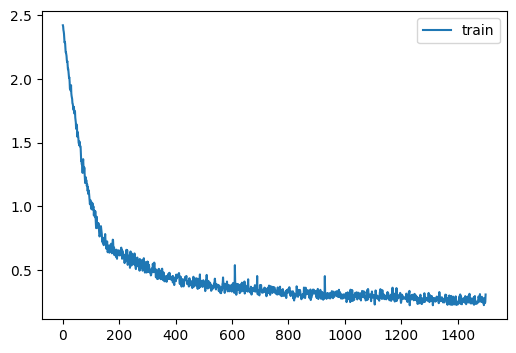

Fit 50 in: 227.53s, setup: 0.00s, 4.26 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9516


In [48]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(2e-3, bs=2048),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, tta=True)

## 95.1% lion(1e-3, bs=2048) mixup(0.1, lbl=0.0) (228.14s)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.162,2.281,0,train
0.349,2.088,0,eval
0.373,1.973,1,train
0.523,1.626,1,eval
0.478,1.653,2,train
0.642,1.221,2,eval
0.592,1.333,3,train
0.716,0.921,3,eval
0.677,1.085,4,train
0.744,0.713,4,eval


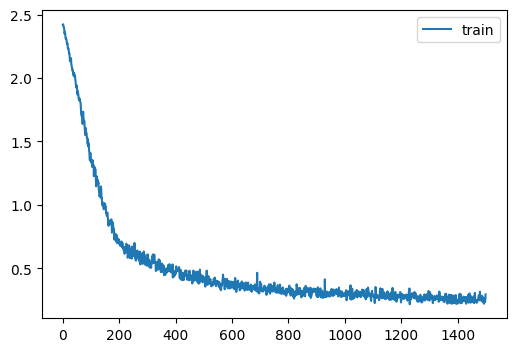

Fit 50 in: 228.14s, setup: 0.00s, 4.27 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.951


In [57]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=2048),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, tta=True)

## 95.08% lion(1e-3, bs=2048) mixup -lbl_smoothing

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.156,2.294,0,train
0.312,2.088,0,eval
0.351,2.023,1,train
0.513,1.623,1,eval
0.445,1.766,2,train
0.640,1.209,2,eval
0.558,1.503,3,train
0.707,0.921,3,eval
0.646,1.311,4,train
0.740,0.737,4,eval


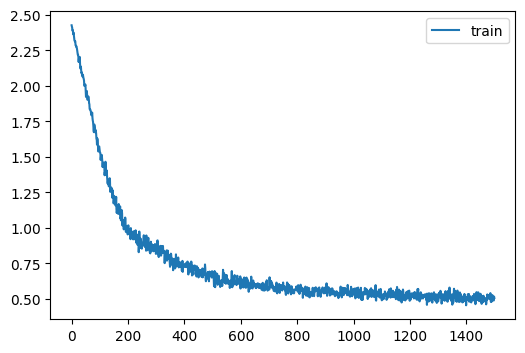

Fit 50 in: 229.91s, setup: 0.00s, 4.30 ± 0.03s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9508


In [58]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=2048),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0),
            epochs=50, tta=True)

## 95.27% lion(1e-3, bs=2048), mixup(0.4, lbl=0.1)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.156,2.301,0,train
0.315,2.088,0,eval
0.350,2.062,1,train
0.519,1.625,1,eval
0.447,1.850,2,train
0.644,1.209,2,eval
0.565,1.654,3,train
0.715,0.925,3,eval
0.651,1.517,4,train
0.737,0.806,4,eval


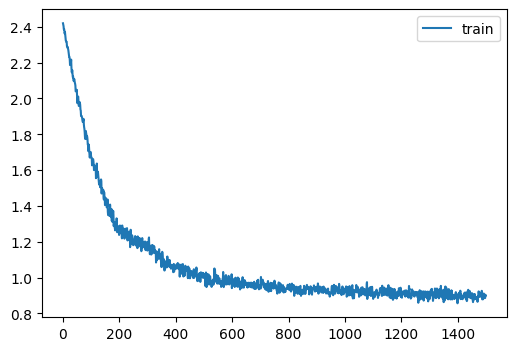

Fit 50 in: 229.87s, setup: 0.00s, 4.30 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9527


In [59]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=2048),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, tta=True)

## 95.44% adamw(1e-2,bs=512) (285.39s)

Reseed: 205811062
Batch size 512
Reseed: 205811062


accuracy,loss,epoch,train
0.621,1.537,0,train
0.812,0.551,0,eval
0.777,1.221,1,train
0.859,0.470,1,eval
0.804,1.149,2,train
0.881,0.419,2,eval
0.816,1.113,3,train
0.882,0.415,3,eval
0.821,1.099,4,train
0.881,0.411,4,eval


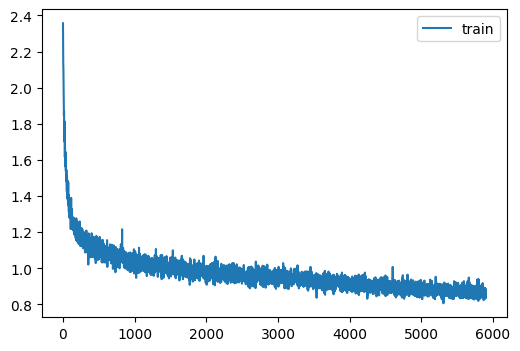

Fit 50 in: 293.75s, setup: 0.00s, 5.57 ± 0.14s per epoch, 0.04 ± 0.01s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9544


In [9]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            adamw(1e-2,bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, tta=True)

## 95.78% lion(1e-3,bs=512) (285.39s) resnet18d

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.058,0,train
0.617,1.335,0,eval
0.580,1.632,1,train
0.737,0.825,1,eval
0.709,1.383,2,train
0.821,0.541,2,eval
0.778,1.218,3,train
0.868,0.415,3,eval
0.807,1.139,4,train
0.891,0.359,4,eval


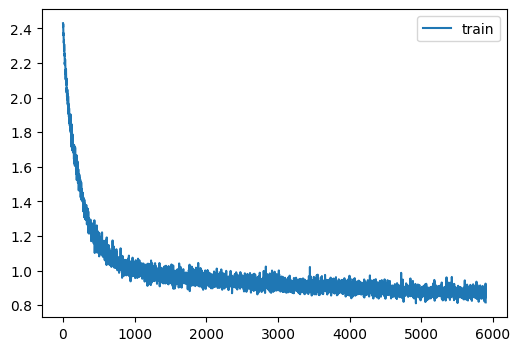

Fit 50 in: 285.39s, setup: 0.00s, 5.40 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9578


In [61]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3,bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, tta=True)

### 95.39% no lblsmooth

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.328,2.014,0,train
0.605,1.335,0,eval
0.573,1.479,1,train
0.728,0.820,1,eval
0.702,1.151,2,train
0.815,0.506,2,eval
0.772,0.926,3,train
0.867,0.372,3,eval
0.797,0.827,4,train
0.892,0.308,4,eval


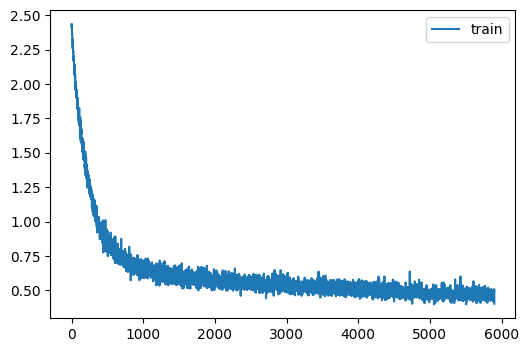

Fit 50 in: 285.35s, setup: 0.00s, 5.40 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9539


In [68]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.53% drop_rate=0.5

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.311,2.073,0,train
0.615,1.338,0,eval
0.564,1.647,1,train
0.735,0.832,1,eval
0.699,1.400,2,train
0.819,0.547,2,eval
0.772,1.232,3,train
0.867,0.419,3,eval
0.804,1.147,4,train
0.892,0.357,4,eval


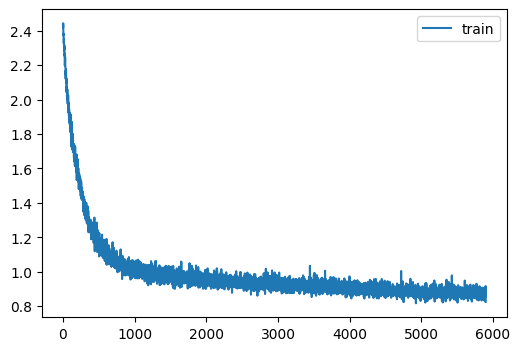

Fit 50 in: 285.24s, setup: 0.00s, 5.40 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9553


In [66]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.5),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.31% RandErase 0.3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.298,2.091,0,train
0.585,1.355,0,eval
0.534,1.685,1,train
0.718,0.854,1,eval
0.671,1.445,2,train
0.804,0.576,2,eval
0.746,1.279,3,train
0.842,0.471,3,eval
0.780,1.197,4,train
0.883,0.371,4,eval


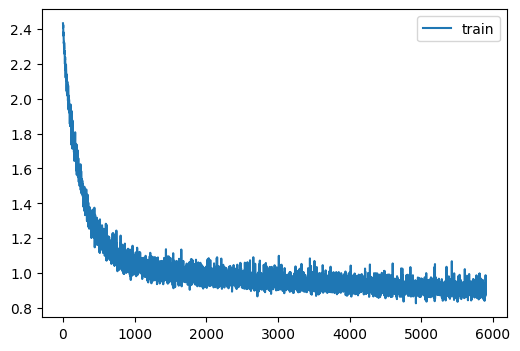

Fit 50 in: 285.96s, setup: 0.00s, 5.41 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9531


In [67]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.61% drop_rate 0.2

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.323,2.072,0,train
0.593,1.349,0,eval
0.559,1.665,1,train
0.718,0.848,1,eval
0.684,1.424,2,train
0.809,0.570,2,eval
0.756,1.256,3,train
0.854,0.452,3,eval
0.783,1.184,4,train
0.883,0.378,4,eval


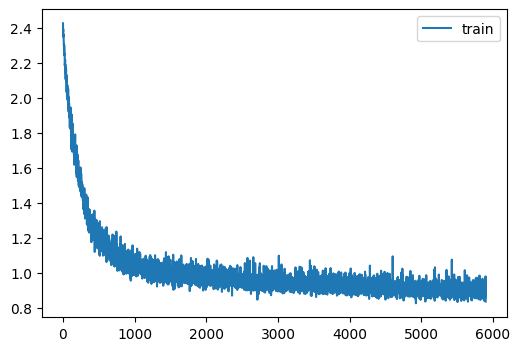

Fit 50 in: 286.12s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9561


In [74]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.2),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.64% MixUp 0.5

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.326,2.066,0,train
0.630,1.326,0,eval
0.580,1.653,1,train
0.737,0.821,1,eval
0.701,1.413,2,train
0.815,0.565,2,eval
0.769,1.252,3,train
0.868,0.414,3,eval
0.797,1.174,4,train
0.882,0.399,4,eval


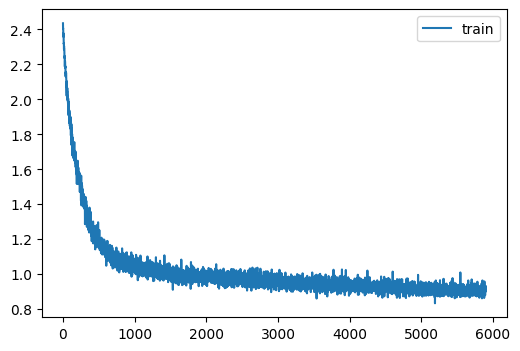

Fit 50 in: 286.34s, setup: 0.00s, 5.42 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9564


In [72]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.5, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.51% MixUp 0.3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.334,2.044,0,train
0.629,1.329,0,eval
0.597,1.590,1,train
0.727,0.837,1,eval
0.715,1.339,2,train
0.830,0.538,2,eval
0.786,1.174,3,train
0.872,0.392,3,eval
0.822,1.090,4,train
0.883,0.381,4,eval


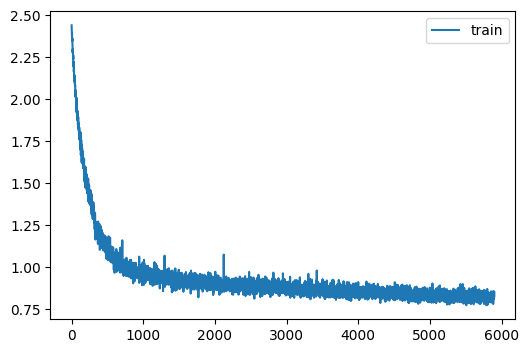

Fit 50 in: 285.70s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9551


In [78]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.3, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### BS 1024 lr 2e-3

Reseed: 1
Batch size 1024
Reseed: 1


accuracy,loss,epoch,train
0.328,2.058,0,train
0.608,1.340,0,eval
0.569,1.647,1,train
0.731,0.847,1,eval
0.693,1.423,2,train
0.787,0.629,2,eval
0.762,1.259,3,train
0.826,0.514,3,eval
0.784,1.193,4,train
0.861,0.431,4,eval


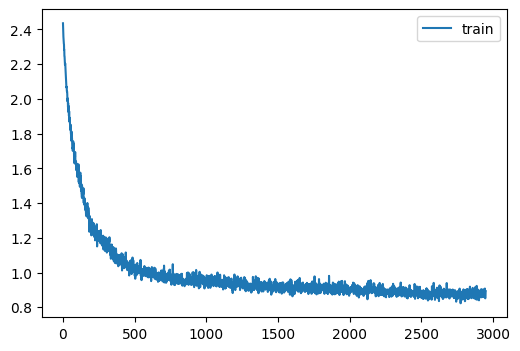

Fit 50 in: 247.86s, setup: 0.00s, 4.66 ± 0.06s per epoch, 0.07 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9552


In [79]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=1024, base_lr=2e-3, tta=True)

## 20ep - 94.84% bs=512 1e-3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.347,2.023,0,train
0.672,1.140,0,eval
0.656,1.488,1,train
0.802,0.568,1,eval
0.772,1.233,2,train
0.878,0.379,2,eval
0.808,1.133,3,train
0.889,0.370,3,eval
0.831,1.065,4,train
0.907,0.322,4,eval


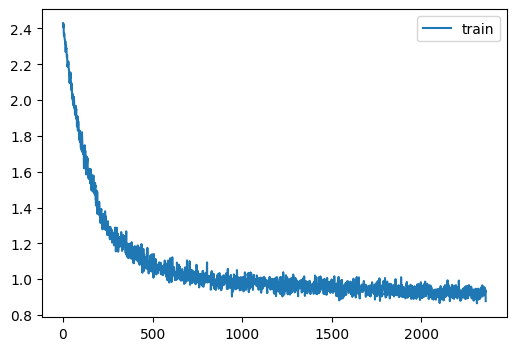

Fit 20 in: 114.08s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9484


In [64]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=20, bs=512, base_lr=1e-2/10, tta=True)

## 50ep - 95.55% bs=256 1e-3

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.595,1.569,0,train
0.809,0.572,0,eval
0.766,1.237,1,train
0.865,0.441,1,eval
0.804,1.134,2,train
0.887,0.383,2,eval
0.827,1.079,3,train
0.898,0.371,3,eval
0.835,1.054,4,train
0.911,0.322,4,eval


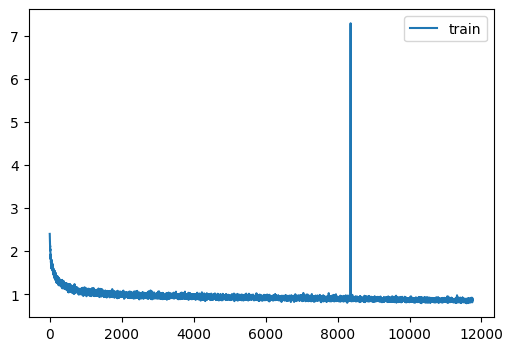

Fit 50 in: 814.58s, setup: 0.00s, 15.53 ± 0.05s per epoch, 0.06 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9555


In [60]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=Lion, base_lr=1e-3,
            epochs=50, tta=True)

## 50ep - 95.74% bs=512 1e-3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.508,1.727,0,train
0.745,0.732,0,eval
0.706,1.367,1,train
0.796,0.584,1,eval
0.773,1.222,2,train
0.860,0.450,2,eval
0.805,1.134,3,train
0.877,0.402,3,eval
0.823,1.087,4,train
0.888,0.365,4,eval


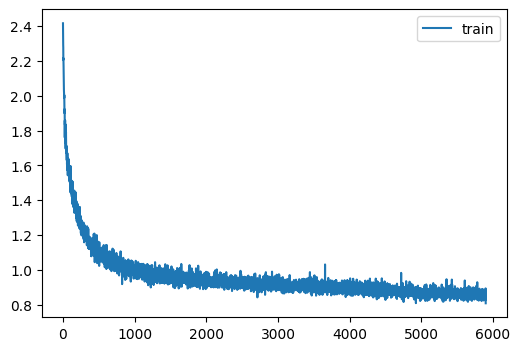

Fit 50 in: 676.93s, setup: 0.00s, 12.82 ± 0.06s per epoch, 0.10 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9574


In [62]:
# Can i get around the peak in loss using larger bs?
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=Lion, base_lr=1e-2/10, bs=512,
            epochs=50, tta=True)

## 50ep - ???5% bs=256 2e-2 AdamW

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.714,1.341,0,train
0.852,0.469,0,eval
0.789,1.173,1,train
0.868,0.418,1,eval
0.808,1.125,2,train
0.877,0.421,2,eval
0.820,1.092,3,train
0.899,0.435,3,eval
0.826,1.074,4,train
0.887,0.408,4,eval


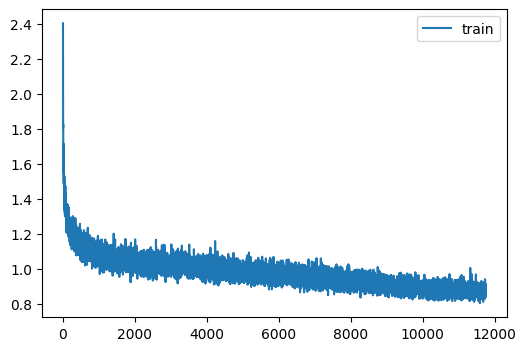

Fit 50 in: 852.79s, setup: 0.00s, 16.29 ± 0.14s per epoch, 0.07 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9556


In [6]:
RNG.set_seed(1)
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(optim.AdamW, weight_decay=0.0), base_lr=2e-2,
            epochs=50, tta=True)

## 50ep - ???5% bs=256 2e-2 AdamW

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.714,1.341,0,train
0.851,0.472,0,eval
0.789,1.173,1,train
0.870,0.412,1,eval
0.807,1.124,2,train
0.871,0.435,2,eval
0.820,1.094,3,train
0.898,0.404,3,eval
0.825,1.076,4,train
0.886,0.395,4,eval


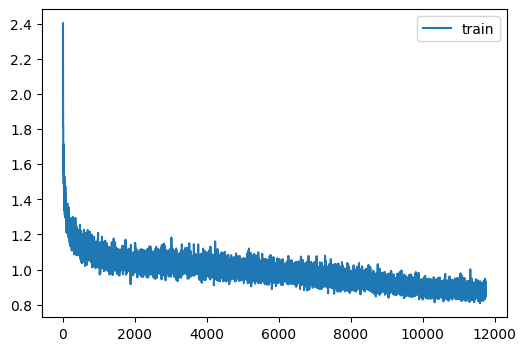

Fit 50 in: 851.19s, setup: 0.00s, 16.26 ± 0.04s per epoch, 0.07 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9556


In [7]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            base_lr=2e-2,
            epochs=50, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.725,1.314,0,train
0.850,0.482,0,eval
0.796,1.156,1,train
0.875,0.430,1,eval
0.813,1.109,2,train
0.886,0.401,2,eval
0.828,1.075,3,train
0.869,0.478,3,eval
0.829,1.062,4,train
0.881,0.434,4,eval


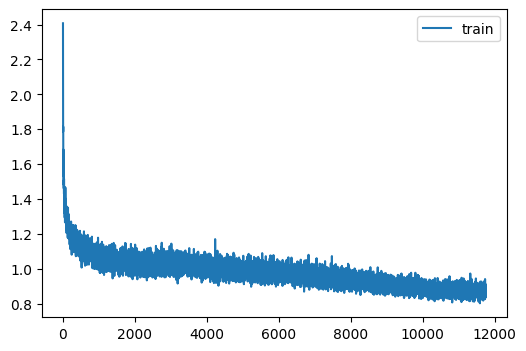

Fit 50 in: 852.27s, setup: 0.00s, 16.28 ± 0.04s per epoch, 0.07 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9554


In [8]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.15)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            base_lr=2e-2,
            epochs=50, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.494,1.721,0,train
0.813,0.557,0,eval
0.757,1.247,1,train
0.864,0.448,1,eval
0.783,1.181,2,train
0.851,0.454,2,eval
0.802,1.139,3,train
0.885,0.398,3,eval
0.808,1.126,4,train
0.887,0.401,4,eval


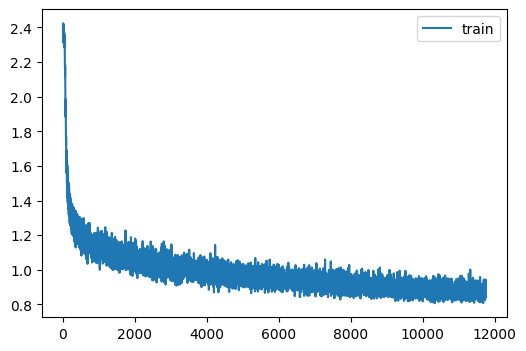

Fit 50 in: 1318.65s, setup: 0.00s, 25.61 ± 0.07s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9555


In [14]:
import dadaptation
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.25)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [ ]:
save_model(learn, 'resnet50d_0.25')

# mixup tta

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.058,0,train
0.617,1.335,0,eval
0.580,1.632,1,train
0.737,0.825,1,eval
0.709,1.383,2,train
0.821,0.541,2,eval
0.778,1.218,3,train
0.868,0.415,3,eval
0.807,1.139,4,train
0.891,0.359,4,eval


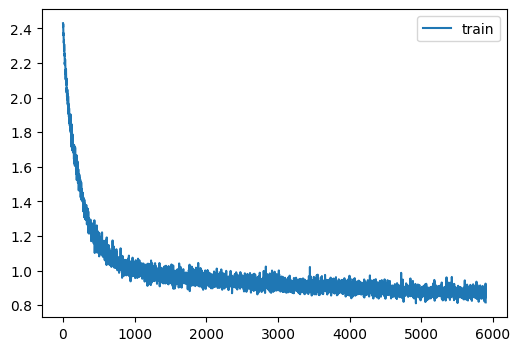

Fit 50 in: 286.84s, setup: 0.00s, 5.43 ± 0.14s per epoch, 0.04 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9578


In [10]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, tta=True)

### TTAMixup impl

In [45]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)

In [50]:
from torcheval.metrics.functional import multiclass_accuracy
from miniai.mixup import mixup_data_int, MixUpCB

class TTAMixUpCB(Callback):
    def __init__(self, count=10, lam=0.1, lam_fun=None, num_classes=10): 
        fc.store_attr() 
        if self.lam_fun is None: self.lam_fun = lambda _:tensor(self.lam)
        
    def before_fit(self,learn):
        self.xb, self.yb = None, None
        self.yb_oh = None
        self.all_preds = [] 
        self.all_targs = []
       
        
    def predict(self, learn):
        if learn.training: return super().predict(learn)
        
        if getattr(self,'yb_oh', None) is None:
            self.xb, self.yb = next(iter(learn.dls.train))
            self.xb.to(def_device)
            self.yb.to(def_device)
            self.yb_oh = F.one_hot(self.yb).float()
        
        x_test, y_test = learn.batch
        votes = None
        for x_train, y_train in zip(self.xb[:self.count], self.yb):
            x_train = x_train[None].expand(x_test.shape).to(def_device)
            y_train = y_train[None].expand(y_test.shape).to(def_device)
            y_train_oh = F.one_hot(y_train, 10)
            
            r = mixup_data_int((x_test, y_test), (x_train, y_train), sampler=self.lam_fun, permute_1=False)
            mixed_preds = learn.model(r.mixed_x).softmax(-1) 
            preds = (mixed_preds - r.lam*y_train_oh)/(1-r.lam)
            #preds = (preds > 0.5).float()
            if votes is None:
                votes = preds 
            else:
                votes += preds
        self.all_preds.append(votes)
        self.all_targs.append(y_test)
        #raise CancelFitException()
    def after_fit(self,learn):
        self.all_preds = torch.cat(self.all_preds)
        self.all_targs = torch.cat(self.all_targs) 

In [51]:
    
def mixup_tta(learn, m=10, lam=0.01, cbs=tuple()):
    
    tta = TTAMixUpCB(m, lam=lam)
    cb = CapturePreds()
    learn.fit(cbs=[cb, tta, ProgressCB(), *cbs], train=False)

    tta_p = tta.all_preds.softmax(-1).cpu()
    raw_p = cb.all_preds.softmax(-1).cpu()
    lbl = tta.all_targs.cpu()

    print('softmax_tta:', multiclass_accuracy(tta_p, lbl).item())
    print('raw_tta:', multiclass_accuracy(raw_p, lbl).item())
    print("tta:", multiclass_accuracy(tta_p+raw_p, lbl).item())
    return (tta_p+raw_p), lbl

In [264]:
preds, lbl = mixup_tta(learn, 100)

Reseed: 1


accuracy,loss,epoch,train
0.957,0.227,0,eval


softmax_tta: 0.9571999907493591
raw_tta: 0.95660001039505
tta: 0.9571999907493591


In [274]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
preds2, lbl2 =  mixup_tta(learn, 100, cbs=[ttacb])

Reseed: 1


accuracy,loss,epoch,train
0.956,0.228,0,eval


softmax_tta: 0.9563999772071838
raw_tta: 0.9557999968528748
tta: 0.9563999772071838


In [278]:
multiclass_accuracy(preds.softmax(-1)+preds2.softmax(-1), lbl)

tensor(0.9579)

#### number of mixed examples

In [283]:
preds, lbl = mixup_tta(learn, 512)

Reseed: 1


accuracy,loss,epoch,train
0.957,0.227,0,eval


softmax_tta: 0.9571999907493591
raw_tta: 0.95660001039505
tta: 0.9571999907493591


In [284]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
preds2, lbl2 =  mixup_tta(learn, 512, cbs=[ttacb])

Reseed: 1


accuracy,loss,epoch,train
0.956,0.228,0,eval


softmax_tta: 0.95660001039505
raw_tta: 0.9557999968528748
tta: 0.95660001039505


In [290]:
multiclass_accuracy(preds.softmax(-1)+preds2.softmax(-1), lbl)

tensor(0.9578)

In [40]:
from miniai.mixup import MixUpCB

## Tests on FP32

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.058,0,train
0.617,1.334,0,eval
0.580,1.632,1,train
0.736,0.825,1,eval
0.709,1.383,2,train
0.821,0.542,2,eval
0.777,1.218,3,train
0.868,0.419,3,eval
0.807,1.139,4,train
0.891,0.356,4,eval


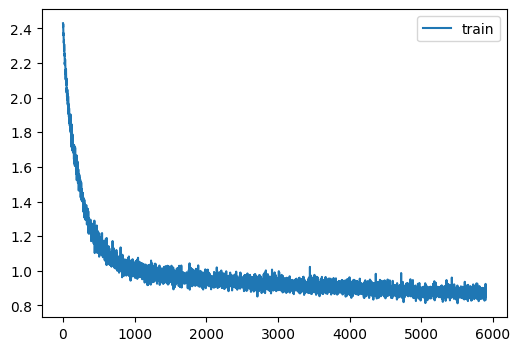

Fit 50 in: 615.25s, setup: 0.00s, 11.62 ± 0.05s per epoch, 0.02 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9557


In [41]:
## 95.78% FP16 95.79 mixup tta 
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpCB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, tta=True)

In [52]:
mixup_tta(learn, 100)

Reseed: 1


accuracy,loss,epoch,train
0.956,0.228,0,eval


softmax_tta: 0.9555000066757202
raw_tta: 0.9563999772071838
tta: 0.9556000232696533


(tensor([[0.0101, 0.0091, 0.0103,  ..., 0.0096, 0.0097, 1.9097],
         [0.0130, 0.0096, 1.8988,  ..., 0.0093, 0.0096, 0.0097],
         [0.0103, 1.9131, 0.0099,  ..., 0.0091, 0.0095, 0.0092],
         ...,
         [0.0112, 0.0109, 0.0113,  ..., 0.0096, 1.9055, 0.0095],
         [0.0098, 1.9122, 0.0089,  ..., 0.0095, 0.0098, 0.0102],
         [0.0112, 0.0104, 0.0092,  ..., 0.0419, 0.0101, 0.0251]]),
 tensor([9, 2, 1,  ..., 8, 1, 5]))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.519,1.678,0,train
0.824,0.534,0,eval
0.772,1.215,1,train
0.869,0.442,1,eval
0.797,1.151,2,train
0.874,0.414,2,eval
0.814,1.114,3,train
0.890,0.391,3,eval
0.818,1.098,4,train
0.890,0.408,4,eval


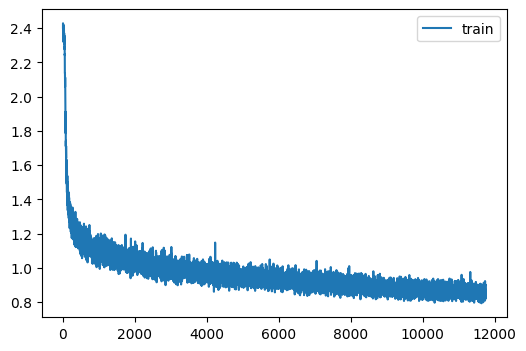

Fit 50 in: 1327.41s, setup: 0.00s, 25.79 ± 0.06s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9582


In [53]:
## 95.82% FP16
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [57]:
preds, lbl = mixup_tta(learn, 100)

Reseed: 1


accuracy,loss,epoch,train
0.955,0.221,0,eval


softmax_tta: 0.9549000263214111
raw_tta: 0.9553999900817871
tta: 0.9549999833106995


In [58]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
preds2, lbl2 =  mixup_tta(learn, 100, cbs=[ttacb])

Reseed: 1


accuracy,loss,epoch,train
0.956,0.222,0,eval


softmax_tta: 0.9549000263214111
raw_tta: 0.9555000066757202
tta: 0.9549000263214111


In [59]:
multiclass_accuracy(preds.softmax(-1)+preds2.softmax(-1), lbl)

tensor(0.9580)

In [60]:
save_model(learn, 'resnet50d_9555_9582')

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.519,1.679,0,train
0.827,0.531,0,eval
0.775,1.211,1,train
0.869,0.437,1,eval
0.797,1.148,2,train
0.868,0.439,2,eval
0.814,1.114,3,train
0.885,0.400,3,eval
0.819,1.096,4,train
0.891,0.396,4,eval


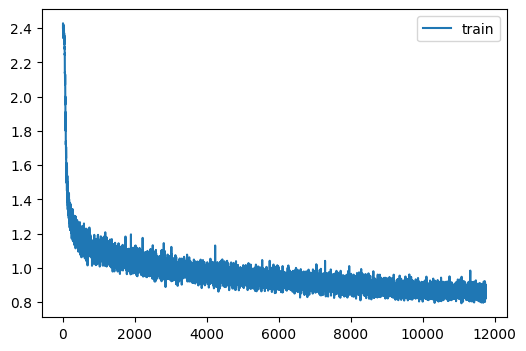

Fit 50 in: 1327.81s, setup: 0.00s, 25.79 ± 0.06s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9573


In [61]:
## 95.82% FP16
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.65),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

## Mixup + bcme

In [31]:
def mixup_bce(preds, r, eta=None, verbose=False, label_smoothing=0.1, **kw): 
    K = preds.shape[-1]
    y1 = F.one_hot(r.y1, K).float()
    y2 = F.one_hot(r.y2, K).float()
    mixed_y = torch.lerp(y2, y1, r.lam.reshape(-1,*[1]*(len(y2.shape)-1)))
    if label_smoothing:
        mixed_y = mixed_y * (1-label_smoothing) + label_smoothing
    if verbose: 
        print(y1)
        print(y2)
        print(r.lam)
        print(f"{mixed_y}")
    return F.binary_cross_entropy_with_logits(preds, mixed_y, **kw)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.262,0.547,0,train
0.485,1.635,0,eval
0.509,0.291,1,train
0.678,1.111,1,eval
0.650,0.226,2,train
0.759,0.667,2,eval
0.744,0.168,3,train
0.825,0.528,3,eval
0.797,0.141,4,train
0.883,0.427,4,eval


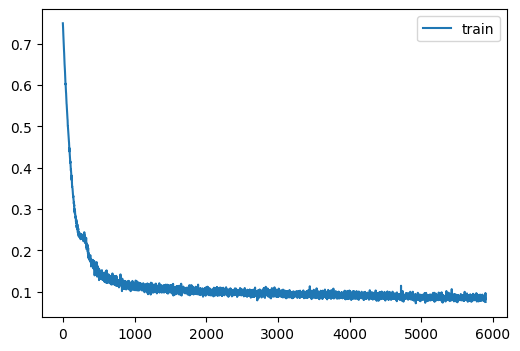

Fit 50 in: 285.52s, setup: 0.00s, 5.41 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9566


In [32]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=mixup_bce),
            epochs=50, tta=True)

In [ ]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1, loss_func=mixup_bce),
            epochs=50, tta=True)

### Mixup + dmce

In [18]:
from miniai.mixup import mce_int, dmce

In [20]:
dmce??

Signature: dmce(preds, r, eta=0.1, verbose=False, **kw)
Docstring: <no docstring>
Source:   
def dmce(preds, r, eta=0.1, verbose=False, **kw): 
    mce = mce_int(preds, r, reduction=False, **kw)
    y1 = F.one_hot(r.y1, preds.shape[-1])
    y2 = F.one_hot(r.y2, preds.shape[-1])
    dmce1 = ce_masked(preds, y1, y2, **kw)
    dmce2 = ce_masked(preds, y2, y1, **kw)
    if verbose: print(f"{mce} + {eta}*{dmce1} + {eta}*{dmce2}")
    return (mce + eta*dmce1 + eta*dmce2).mean()
File:      ~/workspace/part2/course22p2/miniai/mixup.py
Type:      function

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.328,2.200,0,train
0.608,1.336,0,eval
0.574,1.649,1,train
0.731,0.819,1,eval
0.704,1.303,2,train
0.817,0.514,2,eval
0.771,1.056,3,train
0.866,0.379,3,eval
0.793,0.941,4,train
0.893,0.315,4,eval


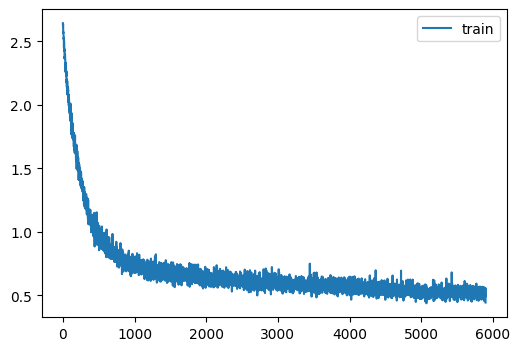

Fit 50 in: 294.67s, setup: 0.00s, 5.59 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9563


In [21]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=dmce, eta=0.05),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.249,0,train
0.619,1.336,0,eval
0.581,1.809,1,train
0.739,0.830,1,eval
0.710,1.540,2,train
0.822,0.547,2,eval
0.776,1.360,3,train
0.869,0.420,3,eval
0.804,1.269,4,train
0.891,0.367,4,eval


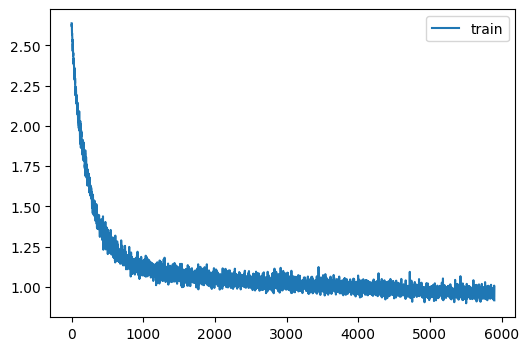

Fit 50 in: 298.18s, setup: 0.00s, 5.66 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9556


In [22]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1, loss_func=dmce, eta=0.05),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.439,0,train
0.621,1.337,0,eval
0.582,1.985,1,train
0.741,0.837,1,eval
0.710,1.696,2,train
0.823,0.553,2,eval
0.775,1.500,3,train
0.870,0.425,3,eval
0.801,1.397,4,train
0.890,0.378,4,eval


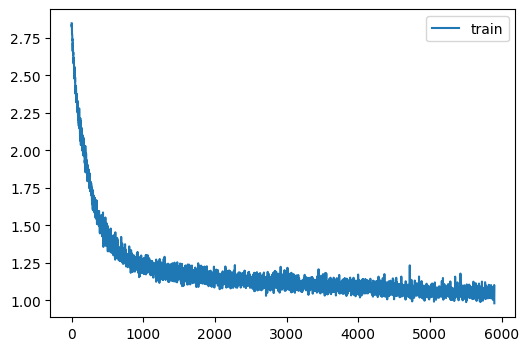

Fit 50 in: 298.43s, setup: 0.00s, 5.66 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9557


In [23]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1, loss_func=dmce, eta=0.1),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.821,0,train
0.625,1.340,0,eval
0.582,2.333,1,train
0.741,0.851,1,eval
0.710,2.004,2,train
0.823,0.567,2,eval
0.771,1.776,3,train
0.871,0.432,3,eval
0.795,1.648,4,train
0.892,0.382,4,eval


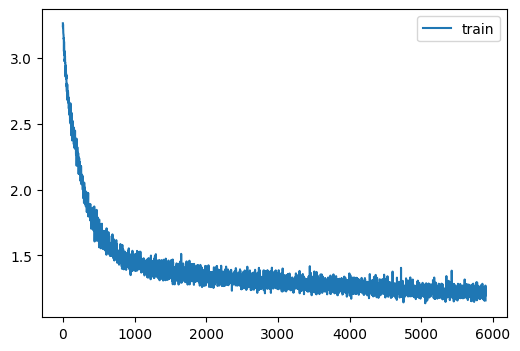

Fit 50 in: 298.47s, setup: 0.00s, 5.67 ± 0.08s per epoch, 0.05 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9548


In [25]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1, loss_func=dmce, eta=0.2),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,3.965,0,train
0.632,1.347,0,eval
0.585,3.368,1,train
0.743,0.881,1,eval
0.707,2.919,2,train
0.815,0.594,2,eval
0.762,2.590,3,train
0.868,0.453,3,eval
0.781,2.390,4,train
0.884,0.415,4,eval


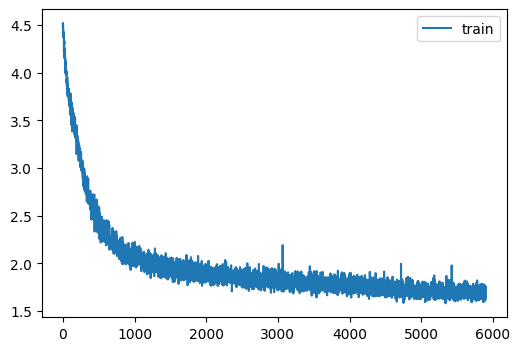

Fit 50 in: 298.28s, setup: 0.00s, 5.66 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9524


In [26]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1, loss_func=dmce, eta=0.5),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.328,3.875,0,train
0.620,1.344,0,eval
0.580,3.140,1,train
0.737,0.848,1,eval
0.702,2.578,2,train
0.812,0.560,2,eval
0.758,2.123,3,train
0.863,0.415,3,eval
0.775,1.858,4,train
0.881,0.377,4,eval


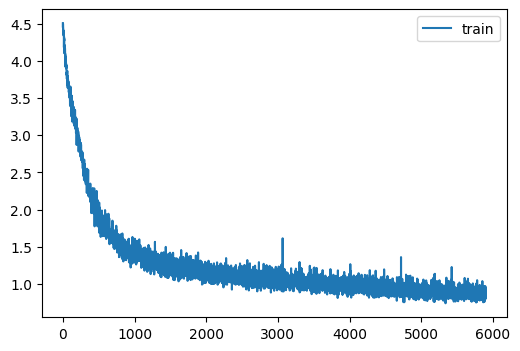

Fit 50 in: 296.69s, setup: 0.00s, 5.63 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9519


In [27]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=dmce, eta=0.5),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.107,43.018,0,train
0.162,2.260,0,eval
0.191,41.442,1,train
0.371,2.039,1,eval
0.326,39.354,2,train
0.501,1.760,2,eval
0.430,37.452,3,train
0.608,1.421,3,eval
0.534,35.139,4,train
0.692,1.153,4,eval


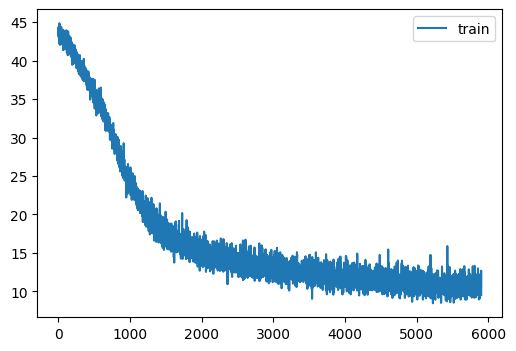

Fit 50 in: 296.39s, setup: 0.00s, 5.62 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9406


In [33]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-4, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=dmce, eta=10),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.322,39.254,0,train
0.631,1.383,0,eval
0.574,33.898,1,train
0.738,0.947,1,eval
0.685,28.525,2,train
0.788,0.670,2,eval
0.717,23.255,3,train
0.844,0.508,3,eval
0.723,19.897,4,train
0.856,0.485,4,eval


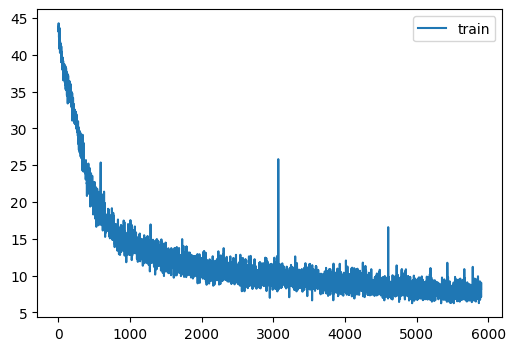

Fit 50 in: 296.65s, setup: 0.00s, 5.63 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9387


In [34]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=dmce, eta=10),
            epochs=50, tta=True)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.328,5.735,0,train
0.628,1.351,0,eval
0.580,4.770,1,train
0.738,0.875,1,eval
0.698,3.956,2,train
0.806,0.590,2,eval
0.747,3.258,3,train
0.858,0.444,3,eval
0.760,2.828,4,train
0.876,0.404,4,eval


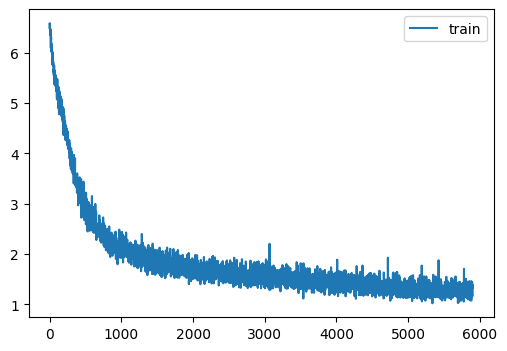

Fit 50 in: 295.67s, setup: 0.00s, 5.61 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9492


In [35]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0, loss_func=dmce, eta=1),
            epochs=50, tta=True)

# Export

In [7]:
import nbdev; nbdev.nbdev_export()